[nltk_data] Downloading package wordnet to /Users/teng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Topic: 0 
Words: 0.015*"model" + 0.014*"price" + 0.011*"forecast" + 0.009*"data" + 0.009*"estim" + 0.008*"function" + 0.008*"market" + 0.008*"time" + 0.007*"cluster" + 0.007*"risk"
Topic: 1 
Words: 0.012*"model" + 0.006*"data" + 0.006*"estim" + 0.006*"market" + 0.005*"risk" + 0.005*"base" + 0.005*"price" + 0.005*"figur" + 0.005*"time" + 0.004*"forecast"
Topic: 2 
Words: 0.013*"model" + 0.008*"data" + 0.007*"risk" + 0.007*"return" + 0.006*"time" + 0.006*"price" + 0.006*"market" + 0.005*"estim" + 0.005*"figur" + 0.004*"portfolio"
Topic: 3 
Words: 0.013*"model" + 0.008*"data" + 0.008*"market" + 0.008*"portfolio" + 0.007*"time" + 0.006*"valu" + 0.006*"return" + 0.006*"paramet" + 0.006*"risk" + 0.006*"figur"
Topic: 4 
Words: 0.010*"model" + 0.006*"cluster" + 0.006*"data" + 0.005*"estim" + 0.005*"risk" + 0.005*"time" + 0.005*"price" + 0.005*"market" + 0.004*"figur" + 0.004*"variabl"
Topic: 5 
Words: 0.010*"model" + 0.009*"cluster" + 0.008*"market" + 0.007*"figur" + 0.006*"data" + 0.006*"pric

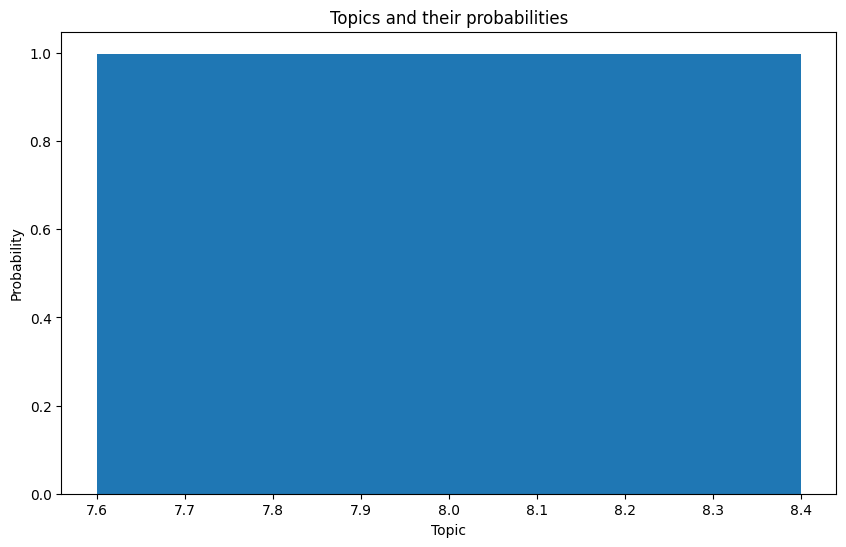

In [5]:
import os
import glob
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
import nltk
import pandas as pd
from collections import defaultdict
from pathlib import Path
import pyLDAvis
import pyLDAvis.gensim
import ssl
import PyPDF2
import pandas as df
import matplotlib.pyplot as plt

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('wordnet')
stemmer = SnowballStemmer(language='english')

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token)) 
    return result

files_folder = f'./full_text/cleaned/cleaned_text/'

results = defaultdict(list)
for file in Path(files_folder).glob('**/*.txt'):
    with open(file, "r") as file_open:
        results["file_name"].append(file.name)
        results["text"].append(file_open.read())

df = pd.DataFrame(results)
data_text = df[['text']]
data_text['index'] = data_text.index
documents = data_text

processed_docs = documents['text'].map(preprocess)
dictionary = gensim.corpora.Dictionary(processed_docs)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

# Folder where the new document is
folder_path = './similar_text/'

# Name of the PDF file
pdf_file_name = '20230415 BW Bingling Wang DISS.pdf' 

# Read in the PDF file
with open(os.path.join(folder_path, pdf_file_name), 'rb') as file:
    pdf_reader = PyPDF2.PdfReader(file)
    new_doc = ''
    for page_num in range(len(pdf_reader.pages)):
        new_doc += pdf_reader.pages[page_num].extract_text()

# Preprocess the new document
new_doc_preprocessed = preprocess(new_doc)

# Transform the document into bag of words format
new_doc_bow = dictionary.doc2bow(new_doc_preprocessed)

# Get the topics
topics = lda_model.get_document_topics(new_doc_bow)

# Print the topics
for topic, probability in topics:
    print(f'Topic: {topic}, Probability: {probability}')


# Prepare data for plotting
topic_nums = [topic for topic, _ in topics]
probabilities = [probability for _, probability in topics]


# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(topic_nums, probabilities)
plt.xlabel('Topic')
plt.ylabel('Probability')
plt.title('Topics and their probabilities')
plt.show()